## Overview:
We are using the 2009 H1n1 and Flu vaccine survey. It is a multilabel, multiclass dataset. There are four possible classes (four sets of twos). However, for simplicity's sake, we are working with predicting just one outcome: the top predictors determining the likelihood of receiving an H1N1 (pandemic) vaccine. 


### Now we look at the data to get a better idea of what we're working with

We have four files prepared for us already: training features and training labels, and test features and test labels.
Should we use this split? Let's look at the breakdowns of target features in test vs train. If needed, we can combine
the data and create our own splits.

In [1]:
# imports

# basic dataframes and math
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,MultiLabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split as tts, KFold, cross_val_score, GridSearchCV
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay




from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# models, preprocessing and evaluation



from catboost import Pool, CatBoostClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier  # have to do all this because otherwise xgbooster kills the kernal
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier # didn't get a chance to try
from sklearn.multioutput import MultiOutputClassifier # didn't get a chance to try
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE, ADASYN





# warnings, misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:

train_features_1 = pd.read_csv('/Users/admin/Documents/Flatiron/H1_N1-Classification-Project/data/training_set_features.csv')
train_targets_1 = pd.read_csv('/Users/admin/Documents/Flatiron/H1_N1-Classification-Project/data/training_set_labels.csv')
test_features_1 = pd.read_csv('/Users/admin/Documents/Flatiron/H1_N1-Classification-Project/data/test_set_features.csv')


In [3]:

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [4]:
# since we are not given our test y(labels) data, I suppose we have to re-create the original dataset and then split it? 
# let's see if our train features and targets are even the same length

np.testing.assert_array_equal(train_features_1.index.values, train_targets_1.index.values)

# no error, so they do match. so where do we get our test data from?
print(train_features_1.shape)
print(train_targets_1.shape)
print(test_features_1.shape)

# hmm, it appears that perhaps the train and test features are in fact the same data, implying we do, in fact,
# need to merge and split fresh. let's look closer

(26707, 36)
(26707, 3)
(26708, 36)


In [5]:
# let's look  at the id numbers, which are pre-given to us as unique
train_features_1.columns
train_features_1['respondent_id'].value_counts()
test_features_1.columns
test_features_1['respondent_id'].value_counts()
train_features_1.assign(Intest_features_1=train_features_1.respondent_id.isin(test_features_1.respondent_id).astype(int))
# no, these all appear unique. let's be certain. 
print(train_features_1.respondent_id.isin(test_features_1.respondent_id).value_counts())

# yes, they're all unique. so the data was just split in half between test and training. i don't understand how
# we're supposed to generate test targets to validate against? unless they're just still inside the test data?


False    26707
Name: respondent_id, dtype: int64


In [6]:
train_targets_1.info()

test_features_1.columns

# no, the targets are not in the test data. should we just split up our training data since
# at least it's complete and not use the test set except for making predictions? clearly we can't evaluate 
# our results without test targets. this is how most people did it on github. or should we merge all three sets, resulting in missing targets
# for half the data and then split that up, making sure to stratify? definitely don't want to impute
# maybe it's not that complex, though. maybe the project designers just want us to build the best training model
# we can and they hide the test targets until it's time to submit? it seems that most sources do not advocate
# for using data with half the target data missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [7]:
train_features_1.info()

# not too many nulls, but of those categories with a lot (health insurance, employment info), they seem pretty 
# important! it's well-understood that these are proxies in many cases for education, which correlates strongly with
# vaccine acceptance, at least in the US. however, there is an education category, so depending on how strong it is,
# we might be able to drop these categories, as they would cause multicollinearity. however, there is probably
# good data in those categories that we would not want to throw away. we would have to seriously consider how we would
# weight these. imputation would likely not be a good strategy. we should probably drop the nulls within the column
# but then preserve them in a separate column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [8]:
# explore class and feature balances

# employment_industry, employment_occupation, and health_insurance are half-null in the training data. what are they
# in the test?

test_features_1.info()

# also approximately half, so well-balanced in terms of nulls



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

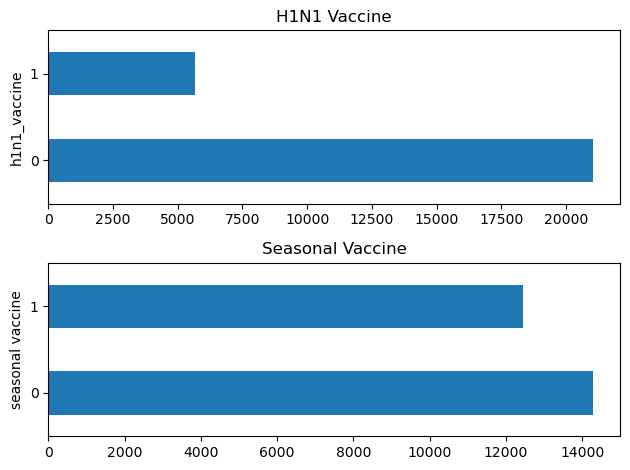

In [9]:
# class balance

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2, 1)


#H1N1 
train_targets_1['h1n1_vaccine'].value_counts().plot.barh(title="H1N1 Vaccine", ax=ax[0])
ax[0].set_ylabel("h1n1_vaccine")

#Seasonal Vaccine
train_targets_1['seasonal_vaccine'].value_counts().plot.barh(title="Seasonal Vaccine", ax=ax[1])
ax[1].set_ylabel("seasonal vaccine")

fig.tight_layout()

In [10]:
# as we can see, the flu vaccine values are pretty balanced, but h1n1 vaccines are highly imbalanced. will have to
# take account of this in our modeling. 

In [11]:
# explore nulls
train_features_1.isna().sum()


# setting nulls to be less than 5% if we're going to delete them.

lower_threshold_percentage = 0.0

upper_threshold_percentage = 0.05

# Calculate the percentage of null values for each column
null_percentages = train_features_1.isnull().sum() / len(train_features_1)
print(null_percentages)
filtered_columns = null_percentages[
    (null_percentages > lower_threshold_percentage) & (null_percentages < upper_threshold_percentage)
].index.tolist()

#print(filtered_columns)





# so we have quite a few columns where we can safely drop nulls, based on best practices. we assume this will map 
# to the test data. let's check 



respondent_id                  0.000000
h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
age_group                      0.000000
education                      0.052683
race                           0.000000


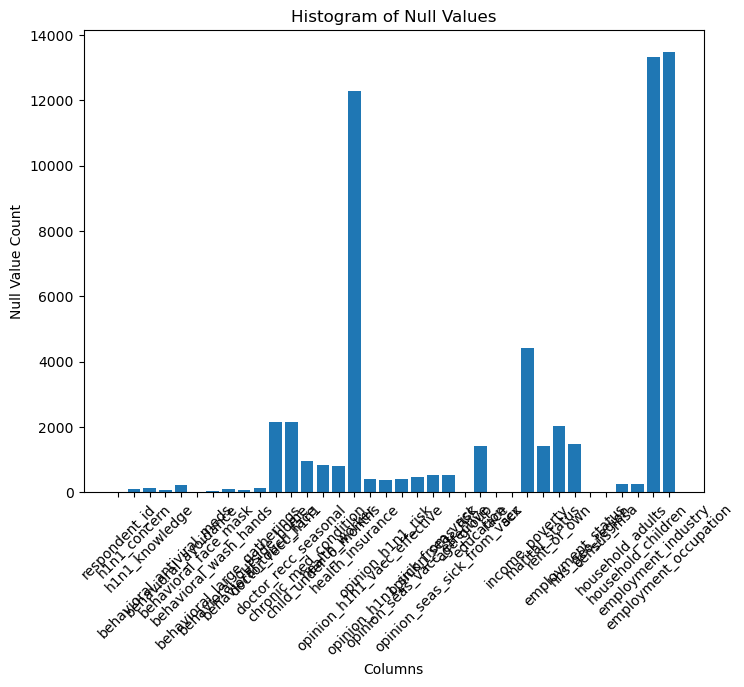

In [12]:
# let's visualize

null_counts = train_features_1.isnull().sum()

# Create a histogram of null values
plt.figure(figsize=(8, 6))
plt.bar(null_counts.index, null_counts.values)
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Histogram of Null Values')
plt.xticks(rotation=45)
plt.show()





In [13]:
null_percentages_2 = test_features_1.isnull().sum() / len(train_features_1)

filtered_columns_2 = null_percentages_2 [
    (null_percentages_2  > lower_threshold_percentage) & (null_percentages_2  <= upper_threshold_percentage)
].index.tolist()


sorted(list(filtered_columns_2)) == sorted(list(filtered_columns))

# they're the same! so our training feature data is representative in respect to the nulls we can drop.

True

In [14]:
# let's go ahead and merge our training data, since we've established it's a represenative sample (relative to
# the other sample AKA test features)

In [15]:
# set indices
train_features_1 = train_features_1.set_index('respondent_id')
train_targets_1 = train_targets_1.set_index('respondent_id')

# merge

train_merged = train_features_1.merge(train_targets_1, on='respondent_id', how='inner')
train_merged.head()

train_merged.isna().sum()
train_merged.shape

(26707, 37)

In [16]:
train_merged.isna().sum()

# Drop null values from the filtered columns

merged_filtered = train_merged.dropna(subset=filtered_columns)
merged_filtered.head()
merged_filtered.shape
merged_filtered.isna().sum()

h1n1_concern                       0
h1n1_knowledge                     0
behavioral_antiviral_meds          0
behavioral_avoidance               0
behavioral_face_mask               0
behavioral_wash_hands              0
behavioral_large_gatherings        0
behavioral_outside_home            0
behavioral_touch_face              0
doctor_recc_h1n1                1827
doctor_recc_seasonal            1827
chronic_med_condition              0
child_under_6_months               0
health_worker                      0
health_insurance               10981
opinion_h1n1_vacc_effective        0
opinion_h1n1_risk                  0
opinion_h1n1_sick_from_vacc        0
opinion_seas_vacc_effective        0
opinion_seas_risk                  0
opinion_seas_sick_from_vacc        0
age_group                          0
education                        523
race                               0
sex                                0
income_poverty                  3284
marital_status                   522
r

In [17]:
# let's look both at zero values and nulls

def zeroes_and_nulls(df):
    zeroes = (df == 0.00).astype(int).sum(axis=0)
    nulls = df.isnull().sum()
    nulls_percent = 100 * df.isnull().sum() / len(df)
    zero_nulls_table = pd.concat([zeroes, nulls, nulls_percent], axis=1)
    zero_nulls_table = zero_nulls_table.rename(
        columns = {0:'Zero Values',
                   1:'Missing Values',
                   2:'% Missing of Total Values'})
    zero_nulls_table['Total Zero or Missing Values'] = zero_nulls_table['Zero Values'] + zero_nulls_table['Missing Values']
    zero_nulls_table['% Total Zero or Missing Values'] = 100 * zero_nulls_table['Total Zero or Missing Values'] / len(df)
    zero_nulls_table['Data Type'] = df.dtypes
    zero_nulls_table = zero_nulls_table[zero_nulls_table.iloc[:,1] != 0].sort_values( '% Missing of Total Values', ascending=False).round(1)
    
    return zero_nulls_table



In [18]:
zeroes_and_nulls(merged_filtered)

,Zero Values,Missing Values,% Missing of Total Values,Total Zero or Missing Values,% Total Zero or Missing Values,Data Type
employment_occupation,0,11966,48.2,11966,48.2,object
employment_industry,0,11839,47.7,11839,47.7,object
health_insurance,1666,10981,44.3,12647,51.0,float64
income_poverty,0,3284,13.2,3284,13.2,object
doctor_recc_h1n1,17870,1827,7.4,19697,79.4,float64
doctor_recc_seasonal,15347,1827,7.4,17174,69.2,float64
rent_or_own,0,1108,4.5,1108,4.5,object
employment_status,0,571,2.3,571,2.3,object
education,0,523,2.1,523,2.1,object
marital_status,0,522,2.1,522,2.1,object


In [19]:
# hmmm, looks like we have even more columns with less than 5% nulls that we could maybe drop? 
# this indicates that certain null fields are correlated!

null_percentages_3 = merged_filtered.isnull().sum() / len(train_features_1)
filtered_columns_3 = null_percentages_3 [
    (null_percentages_3  > lower_threshold_percentage) & (null_percentages_3  <= upper_threshold_percentage)
].index.tolist()

# looking at how the null percentages changed after the first dropna. while I'm tempted to drop more, because
# of my concern about null correlations, I don't want to keep dropping and end up with very biased data

result = null_percentages_2[null_percentages_2.index.isin(null_percentages_3.index)] - null_percentages_3
print(result)

age_group                      0.000000
behavioral_antiviral_meds      0.002958
behavioral_avoidance           0.007975
behavioral_face_mask           0.000711
behavioral_large_gatherings    0.002696
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
behavioral_wash_hands          0.001498
census_msa                     0.000000
child_under_6_months           0.030441
chronic_med_condition          0.034897
doctor_recc_h1n1               0.012469
doctor_recc_seasonal           0.012469
education                      0.033100
employment_industry            0.053769
employment_occupation          0.054667
employment_status              0.033699
h1n1_concern                   0.003183
h1n1_knowledge                 0.004568
h1n1_vaccine                        NaN
health_insurance               0.046692
health_worker                  0.029543
hhs_geo_region                 0.000000
household_adults               0.008425
household_children             0.008425


In [20]:
# it also appears that the columns with zero values are likely simple binary classification.  let's look

print(merged_filtered.doctor_recc_h1n1.value_counts())
print(merged_filtered.doctor_recc_seasonal.value_counts())
print(merged_filtered.health_insurance.value_counts())

# yep, this clearly is the case with two of the columns full of zeroes. but what about health insurance? 
# it should be the same binary classifer, but why so many missing values? is it something that people would
# feel sensitive answering, like with specific information about employment? or maybe it's something to do with
# how the survey was structured? background info being towards the end, meaning the people who don't finish
# the survey would not provide this info? would be interesting to look at the survey itself. * did this and demographic
# questions were at the end, as i figured https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NIS/nhfs/nhfspuf_QUEX.PDF

0.0    17870
1.0     5106
Name: doctor_recc_h1n1, dtype: int64
0.0    15347
1.0     7629
Name: doctor_recc_seasonal, dtype: int64
1.0    12156
0.0     1666
Name: health_insurance, dtype: int64


In [21]:
#  maybe we're getting lost in the weeds. let's look at the profile report

sample = merged_filtered.sample(10000)

profile = ProfileReport(sample, minimal=True)
profile.to_file("output.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# looking at the profile report, we see our data is highly skewed/non-normal, on top of all 
# the missing (and likely MNAR) values. we should probably normalize some of the values, but after the split? 

In [23]:
# imputing missing values or creating new columns? try the latter? for the big null categories


#columns_to_drop_na = ['health_insurance', 'employment_industry', 'employment_occupation']

#for column in columns_to_drop_na:
    #merged_filtered['{}_IsNull'.format(column)] = merged_filtered[column].isnull()
    

#merged_filtered.dropna(subset=columns_to_drop_na, inplace=True)

#merged_filtered.head()
#merged_filtered.shape



<AxesSubplot: >

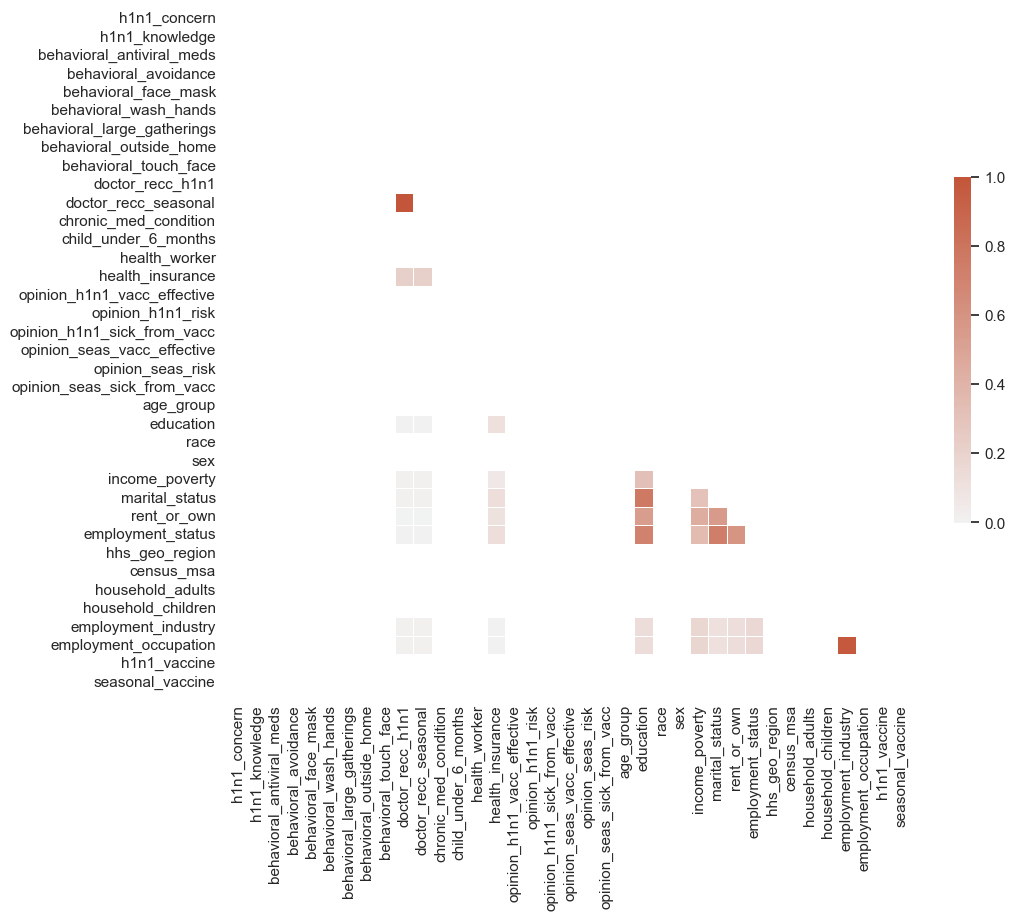

In [24]:
# hmmm, this doesn't seem right. now we only have a small fraction of our previous rows! 

# let's keep the missing data for now, especally since a good chunk of it appears MNAR (missing not at random)

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/

# we'll attempt to see statistically if the missing values are MNAR or not:

# R has something like this. Trying to find something in Python: https://rdrr.io/cran/finalfit/man/missing_pairs.html

from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")



# Compute the correlation matrix
corr = merged_filtered.isnull().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


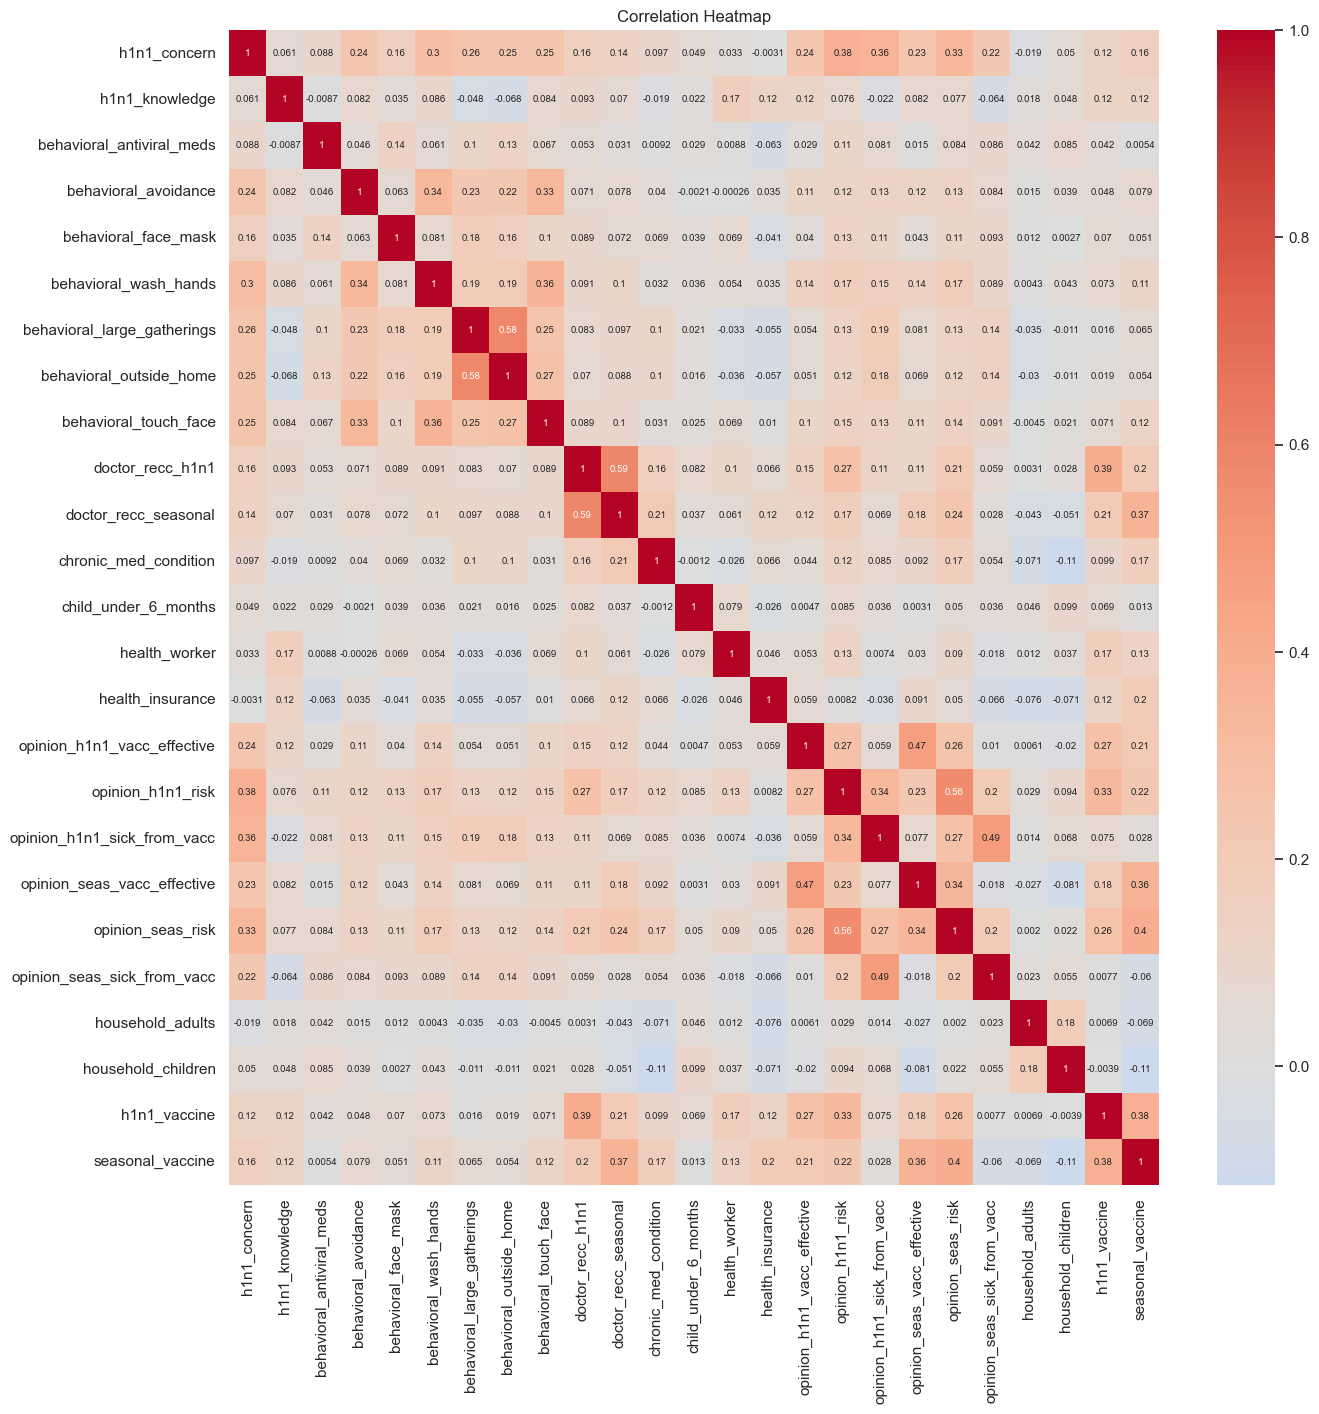

In [25]:
# hmmm, looks like the big employment category nulls are pretty strongly correlated with each other, and the health insurance 
# question is also moderately correlated with other nulls

# let's also look non-null correlated features and see if the same pattern applies?

corr = merged_filtered.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, annot_kws={"size": 35 / np.sqrt(len(corr))}, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# well, this is interesting but doesn't. help us much with understanding the relationships between
# the big null categories. because the data type doesn't work with heatmaps 


In [26]:
# i think we've gone as far as we can go with understanding our nulls (at least for now). 

# should we get rid of any collinear features? the "opininon" of risk columns are near .6, which is a typical
# threshhold for removal. let's get a vif score

y, X = dmatrices('h1n1_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



,VIF,variable
0,5.623849,Intercept
1,1.466893,opinion_h1n1_risk
2,1.466893,opinion_seas_risk


In [27]:
# now let's do a vif for the other target variable

y, X = dmatrices('seasonal_vaccine ~ doctor_recc_seasonal+doctor_recc_h1n1', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



,VIF,variable
0,1.517967,Intercept
1,1.542967,doctor_recc_seasonal
2,1.542967,doctor_recc_h1n1


In [28]:
# vif scores aren't too bad (1-5 considered moderate). let's keep these features.

In [29]:
# let's look at the other moderately correlated features and get a VIF score


y, X = dmatrices('seasonal_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



,VIF,variable
0,5.623849,Intercept
1,1.466893,opinion_h1n1_risk
2,1.466893,opinion_seas_risk


In [30]:

y, X = dmatrices('h1n1_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,5.623849,Intercept
1,1.466893,opinion_h1n1_risk
2,1.466893,opinion_seas_risk


In [31]:
y, X = dmatrices('seasonal_vaccine ~ behavioral_outside_home+behavioral_large_gatherings', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,1.673572,Intercept
1,1.520031,behavioral_outside_home
2,1.520031,behavioral_large_gatherings


In [32]:
y, X = dmatrices('seasonal_vaccine ~ doctor_recc_h1n1+doctor_recc_seasonal', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,1.517967,Intercept
1,1.542967,doctor_recc_h1n1
2,1.542967,doctor_recc_seasonal


In [33]:
# explore data types and think about which transformations might be needed later 
y, X = dmatrices('h1n1_vaccine ~ doctor_recc_h1n1+doctor_recc_seasonal', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif


,VIF,variable
0,1.517967,Intercept
1,1.542967,doctor_recc_h1n1
2,1.542967,doctor_recc_seasonal


In [34]:
y, X = dmatrices('h1n1_vaccine ~ behavioral_outside_home+behavioral_large_gatherings', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,1.673572,Intercept
1,1.520031,behavioral_outside_home
2,1.520031,behavioral_large_gatherings


In [35]:
# none of our VIF scores are bad, even though they heatmap suggests we should consider removing them. how
# do VIFs work with multilabel, multiclass targets?

In [36]:
# having handled nulls, multicollinearity, and zeroes (and briefly look at distributions), 
# let's also check out duplicates

duplicates = merged_filtered[merged_filtered.duplicated()]
print(len(duplicates))


# no duplicates! cool! 

0


In [37]:


# convering categorical data types (ran into an error below, then splitting in X, y)



num_cols = []
cat_cols = []


for i in merged_filtered.columns:
    if merged_filtered[i].dtype in ['float64', 'int64']:
        num_cols.append(i)
    elif merged_filtered[i].dtype in ['object']:
        cat_cols.append(i)
    else:
        print("error")
        
merged_filtered[cat_cols] = merged_filtered[cat_cols].astype(str)



columns_to_drop = ['h1n1_vaccine']

y = merged_filtered['h1n1_vaccine']


X = merged_filtered.drop('h1n1_vaccine', axis=1)
cats = X.select_dtypes('object').columns

X.loc[:,cats]  = X.loc[:,cats].astype('object')



In [38]:
# had done feature selection before with XGBoost Classifer (which I now can't get to work) and it returned 
# Doctor Recommends 

In [39]:

# let's split the data!



#from skmultilearn.model_selection import iterative_train_test_split
# http://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label
# was getting lots of errors. found solution here: https://github.com/scikit-multilearn/scikit-multilearn/issues/160

# this algorithm works for imbalanced multi-label target data
# X_train, y_train, X_test, y_test = iterative_train_test_split(
    #X.values,
    #y.values,
    #test_size = 0.2

# really wanted to use this, as it seems perfect, but it's too buggy and not enough documentation 
X_train,X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)



In [40]:

num_cols = []
cat_cols = []


for i in X.columns:
    if X[i].dtype in ['float64', 'int64']:
        num_cols.append(i)
    elif X[i].dtype in ['object']:
        cat_cols.append(i)
    else:
        print("error")
        


In [41]:
# simple transform pipeline

num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),   
    ('standard', StandardScaler())                                    
])

cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])

In [42]:
# simple preprocess 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])



In [43]:

# can't find a way to run this without it killing the kernal. worked on it for about an hour.
# xgb = Pipeline([
#     ('preprocessor', preprocessor),
#     ('model', XGBClassifier())
# ])

# xgb.fit(X_train, y_train)
# #Predicting on test
# y_pred=xgb.predict(X_test)
# xgb.score(X_train, y_train)



In [44]:
# let's start out with a simple 'base' model 

logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('cat', LogisticRegression())
])

logreg.fit(X_train, y_train)
#Predicting on test
y_pred=logreg.predict(X_test)

logreg.score(X_train,y_train)



0.8543704977959359

In [45]:
names = ['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'x0_18 - 34 Years', 'x0_35 - 44 Years', 'x0_45 - 54 Years',
 'x0_55 - 64 Years', 'x0_65+ Years',
 'x1_12 Years', 'x1_< 12 Years',
 'x1_College Graduate', 'x1_Some College', 'x1_nan',
 'x2_Black', 'x2_Hispanic', 'x2_Other or Multiple', 'x2_White',
 'x3_Female', 'x3_Male',
 'x4_<= $75,000, Above Poverty', 'x4_> $75,000', 'x4_Below Poverty', 'x4_nan'
 'x5_Married', 'x5_Not Married', 'x5_nan',
 'x6_Own', 'x6_Rent', 'x6_nan',
 'x7_Employed', 'x7_Not in Labor Force', 'x7_Unemployed', 'x7_nan'
 'x8_bhuqouqj', 'x8_dqpwygqj', 'x8_fpwskwrf', 'x8_kbazzjca','x8_lrircsnp', 'x8_lzgpxyit', 'x8_mlyzmhmf',
 'x8_oxchjgsf','x8_qufhixun',
 'x9_MSA, Not Principle  City', 'x9_MSA, Principle City', 'x9_Non-MSA',
 'household_adults',
 'household_children',
 'x10_atmlpfrs', 'x10_cfqqtusy', 'x10_dotnnunm', 'x10_fcxhlnwr',
 'x10_haxffmxo', 'x10_ldnlellj', 'x10_mcubkhph', 'x10_mfikgejo',
 'x10_msuufmds', 'x10_nan', 'x10_nduyfdeo', 'x10_phxvnwax',
 'x11_bxpfxfdn', 'x11_ccgxvspp', 'x11_cmhcxjea',
 'x11_dcjcmpih', 'x11_dlvbwzss', 'x11_emcorrxb', 'x11_haliazsg',
 'x11_hfxkjkmi', 'x11_hodpvpew', 'x11_kldqjyjy', 'x11_mxkfnird',
 'x11_nan', 'x11_oijqvulv', 'x11_pvmttkik', 'x11_qxajmpny',
 'x11_rcertsgn', 'x11_tfqavkke', 'x11_ukymxvdu', 'x11_uqqtjvyb',
 'x11_vlluhbov', 'x11_xgwztkwe', 'x11_xqwwgdyp', 'x11_xtkaffoo',
 'x11_xzmlyyjv',
 'seasonal_vaccine']

In [46]:
logreg.steps[0][1].transformers_[1][1].steps[1][1].get_feature_names_out()

array(['x0_18 - 34 Years', 'x0_35 - 44 Years', 'x0_45 - 54 Years',
       'x0_55 - 64 Years', 'x0_65+ Years', 'x1_12 Years', 'x1_< 12 Years',
       'x1_College Graduate', 'x1_Some College', 'x1_nan', 'x2_Black',
       'x2_Hispanic', 'x2_Other or Multiple', 'x2_White', 'x3_Female',
       'x3_Male', 'x4_<= $75,000, Above Poverty', 'x4_> $75,000',
       'x4_Below Poverty', 'x4_nan', 'x5_Married', 'x5_Not Married',
       'x5_nan', 'x6_Own', 'x6_Rent', 'x6_nan', 'x7_Employed',
       'x7_Not in Labor Force', 'x7_Unemployed', 'x7_nan', 'x8_atmpeygn',
       'x8_bhuqouqj', 'x8_dqpwygqj', 'x8_fpwskwrf', 'x8_kbazzjca',
       'x8_lrircsnp', 'x8_lzgpxyit', 'x8_mlyzmhmf', 'x8_oxchjgsf',
       'x8_qufhixun', 'x9_MSA, Not Principle  City',
       'x9_MSA, Principle City', 'x9_Non-MSA', 'x10_arjwrbjb',
       'x10_atmlpfrs', 'x10_cfqqtusy', 'x10_dotnnunm', 'x10_fcxhlnwr',
       'x10_haxffmxo', 'x10_ldnlellj', 'x10_mcubkhph', 'x10_mfikgejo',
       'x10_msuufmds', 'x10_nan', 'x10_nduyfdeo', 'x

In [47]:
coefs_1= logreg.steps[1][1].coef_
pd.DataFrame(zip(names, coefs_1[0])).sort_values(by =1 , ascending = False)



,0,1
23,x0_45 - 54 Years,0.975068
9,doctor_recc_h1n1,0.905418
92,x11_ukymxvdu,0.830733
72,x10_nan,0.830733
15,opinion_h1n1_vacc_effective,0.711906
78,x11_dcjcmpih,0.595299
16,opinion_h1n1_risk,0.503230
98,x11_xzmlyyjv,0.391542
86,x11_nan,0.349016
81,x11_haliazsg,0.270235


In [48]:
coefs= logreg.steps[1][1].coef_
pd.DataFrame(zip(names, coefs[0])).sort_values(by =1, ascending = False)

,0,1
23,x0_45 - 54 Years,0.975068
9,doctor_recc_h1n1,0.905418
92,x11_ukymxvdu,0.830733
72,x10_nan,0.830733
15,opinion_h1n1_vacc_effective,0.711906
78,x11_dcjcmpih,0.595299
16,opinion_h1n1_risk,0.503230
98,x11_xzmlyyjv,0.391542
86,x11_nan,0.349016
81,x11_haliazsg,0.270235


In [49]:
# not terrible! 
def evaluate(estimator, X_tr, X_te, y_tr, y_te):

    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)

    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
      
    

In [50]:
evaluate(logreg, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8543704977959359
Train Precision: 0.7097199341021416
Train Recall: 0.5409342039176294
Train F1-Score: 0.6139375801624626
**********
Testing Scores:
Test Accuracy: 0.8516368327689082
Test Precision: 0.7023809523809523
Test Recall: 0.5331325301204819
Test F1-Score: 0.6061643835616438


In [51]:
from sklearn.model_selection import cross_validate
cross_validate(logreg, X_train, y_train, return_train_score=True)

{'fit_time': array([1.87119603, 1.8545568 , 1.81957388, 1.72112489, 1.69468904]),
 'score_time': array([0.03228784, 0.03993416, 0.03603315, 0.03078508, 0.03168464]),
 'test_score': array([0.84869659, 0.8452029 , 0.85215054, 0.85483871, 0.8516129 ]),
 'train_score': array([0.85505006, 0.85417647, 0.85519419, 0.85418627, 0.85398468])}

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score

param_grid = {
    'cat__penalty': ['l1', 'l2', 'elasticnet', None],
    'cat__dual': [True, False],
    'cat__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
              
              
grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'
)

grid_search.fit(X_test, y_test)

cv_score = grid_search_logreg.best_score_
test_score = roc_auc_score(y_test, grid_search_logreg.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
print(grid_search_logreg.best_params_)

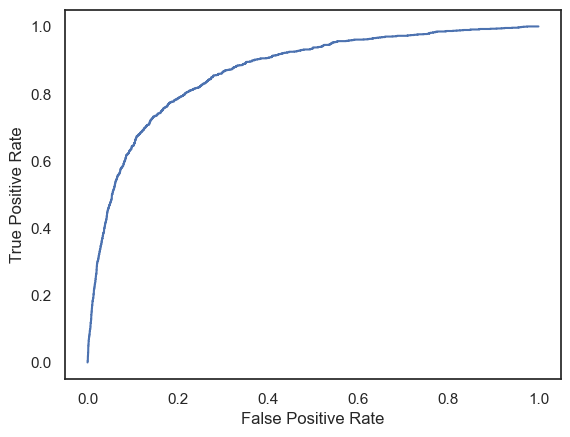

In [53]:
from sklearn.metrics import roc_curve
y_score = logreg.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [166]:
# applying smote to logreg 

from imblearn.pipeline import Pipeline as Pipeline_2
smote_3 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', LogisticRegression())
])

smote_3.fit(X_train, y_train)
y_pred=smote_3.predict(X_test)
# Calculate the score on the resampled data
score = smote_3.score(X_train, y_train)
print("Score on resampled data:", score)

# an improvement! let's cross_validate this

# there was an improvement yesterday, but today it's worse

Score on resampled data: 0.805719815073648


In [57]:
cross_validate(smote_3, X_train, y_train, return_train_score=True)

# we did worse!  

{'fit_time': array([1.87659407, 1.8426733 , 1.84055591, 1.8635118 , 2.08276725]),
 'score_time': array([0.03376603, 0.03292894, 0.03218818, 0.03244328, 0.07346296]),
 'test_score': array([0.80650363, 0.79091642, 0.8077957 , 0.79946237, 0.80510753]),
 'train_score': array([0.80693502, 0.80915261, 0.80634323, 0.80426018, 0.80426018])}

In [111]:
evaluate(smote_3, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.805719815073648
Train Precision: 0.5304434149569821
Train Recall: 0.8051230537418382
Train F1-Score: 0.6395372032714942
**********
Testing Scores:
Test Accuracy: 0.7972907595549105
Test Precision: 0.5177766649974962
Test Recall: 0.7786144578313253
Test F1-Score: 0.621954887218045


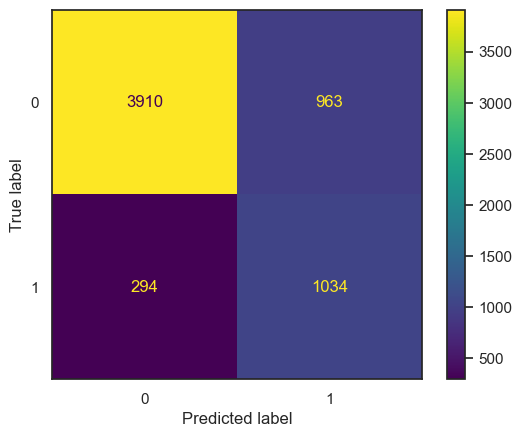

In [126]:
ConfusionMatrixDisplay.from_estimator(smote_3, X_test, y_test)

plt.show()

# good at predicting true negatives. terrible with true positives!

In [58]:


# leveling up with a boosting classifier - gradient boost

gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cat', GradientBoostingClassifier(random_state=42))
])

gbc.fit(X_train, y_train)
#Predicting on test
y_pred=gbc.predict(X_test)

gbc.score(X_train,y_train)

# better than logreg!

0.8752822277174498

In [59]:
evaluate(gbc, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8752822277174498
Train Precision: 0.7726377952755905
Train Recall: 0.5914113510798593
Train F1-Score: 0.6699857752489331
**********
Testing Scores:
Test Accuracy: 0.8701822286727947
Test Precision: 0.7586547972304649
Test Recall: 0.5775602409638554
Test F1-Score: 0.6558358272766139


In [60]:
cross_validate(gbc, X_train, y_train, return_train_score=True)

{'fit_time': array([6.73493719, 6.74408913, 6.72775674, 7.10509706, 7.12886   ]),
 'score_time': array([0.03945804, 0.05316186, 0.03948307, 0.04801583, 0.04328489]),
 'test_score': array([0.86697124, 0.86616501, 0.87392473, 0.87688172, 0.8672043 ]),
 'train_score': array([0.87863719, 0.87830119, 0.87757022, 0.87669668, 0.87703266])}

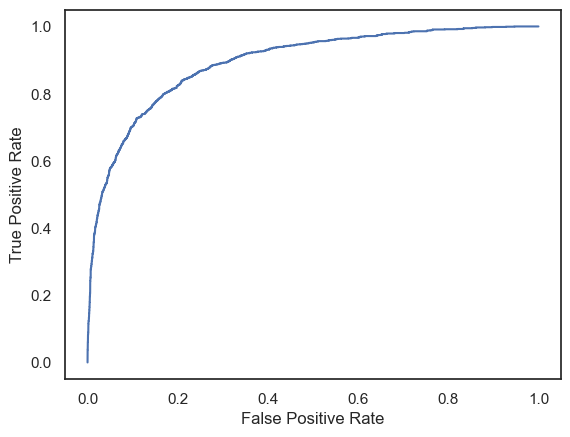

In [61]:
from sklearn.metrics import roc_curve
y_score = gbc.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=gbc.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [63]:
# trying smote on gbc

# 

from imblearn.pipeline import Pipeline as Pipeline_2
smote_4 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', GradientBoostingClassifier(random_state=42))
])

smote_4.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote_4.score(X_train, y_train)
print("Score on resampled data:", score)

# didn't change much! a little worse this time

Score on resampled data: 0.8680787012149231


In [64]:
# let's cross-validate on the smoted gbc

cross_validate(smote_4, X_train, y_train, return_train_score=True)


{'fit_time': array([15.22590017, 15.78409696, 15.18487906, 15.13352799, 15.26928997]),
 'score_time': array([0.04516292, 0.04038692, 0.04015803, 0.04051685, 0.04238486]),
 'test_score': array([0.86186509, 0.85702768, 0.86693548, 0.86854839, 0.86344086]),
 'train_score': array([0.87003562, 0.87050601, 0.86802849, 0.86742373, 0.86883483])}

In [129]:
# we're getting decent results with this, so might want to try a grid search

param_grid = {
    'cat__learning_rate': [.3, .5, .7, .9],
    #'cat__criterion': ['friedman_mse', 'squared_error'],
}
              
              
grid_search_smote_4 = GridSearchCV(
    estimator=smote_4,  # pipeline 
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'  # internal scoring term
)

grid_search_smote_4.fit(X_test, y_test)

cv_score = grid_search_smote_4.best_score_
test_score = roc_auc_score(y_test, grid_search.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# test score diverges a lot from cross-val score. not good! especially with imbalanced data.

Cross-validation score: 0.8761935055943008
Test score: 0.782782371019065


In [131]:
grid_search_smote_4.best_params_

{'cat__learning_rate': 0.3}

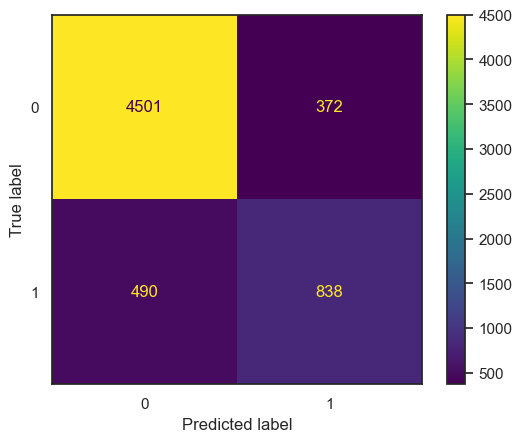

In [125]:
ConfusionMatrixDisplay.from_estimator(smote_4, X_test, y_test)

plt.show()

# this is pretty good with true negatives and true positives, though we could be doing better with the latter

In [87]:
# we can actually do feature importance with this type of classifier, so let's use it

smote_4_features = list(smote_4['cat'].feature_importances_)

df = pd.DataFrame(list(zip(names, smote_4_features)) )

# Sort the DataFrame by the 'Value' column in descending order
df_sorted = df.sort_values(by=1, ascending=False)

# Print the sorted DataFrame

df_sorted 

,0,1
23,x0_45 - 54 Years,0.391556
15,opinion_h1n1_vacc_effective,0.190900
16,opinion_h1n1_risk,0.108949
9,doctor_recc_h1n1,0.093502
14,health_insurance,0.046240
10,doctor_recc_seasonal,0.029098
18,opinion_seas_vacc_effective,0.017172
64,x10_cfqqtusy,0.011919
40,x4_nanx5_Married,0.010823
60,x9_Non-MSA,0.010343


In [112]:
#smoted gbc
evaluate(smote_4, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8680787012149231
Train Precision: 0.713885778275476
Train Recall: 0.640381717729784
Train F1-Score: 0.6751389992057187
**********
Testing Scores:
Test Accuracy: 0.8609901628769553
Test Precision: 0.6925619834710743
Test Recall: 0.6310240963855421
Test F1-Score: 0.6603624901497241


In [88]:
# trying a different kind of gradient boost that was recommend for this kind of data




hgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(loss='log_loss'))
])

hgb.fit(X_train, y_train)

y_pred=hgb.predict(X_test)

hgb.score(X_train,y_train)


0.8916245564993012

In [89]:
evaluate(hgb, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8916245564993012
Train Precision: 0.8032078963602715
Train Recall: 0.6539427423405324
Train F1-Score: 0.7209302325581396
**********
Testing Scores:
Test Accuracy: 0.8680857926140945
Test Precision: 0.7387640449438202
Test Recall: 0.5941265060240963
Test F1-Score: 0.6585976627712854


In [ ]:
cross_validate(hgb, X_train, y_train, return_train_score=True)

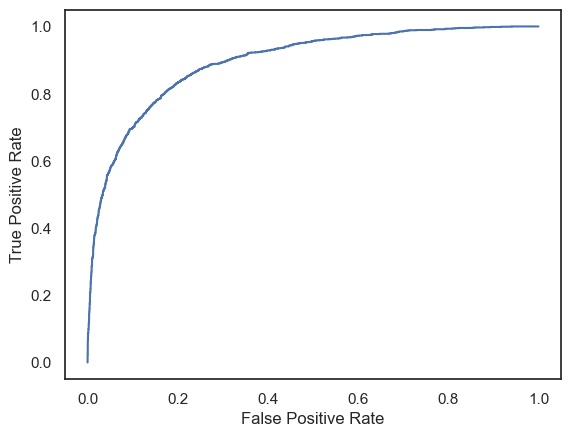

In [90]:
y_score = hgb.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=hgb.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [ ]:
# this is a very good model but it tends to overfit

In [92]:
# going to apply smote to HistGradientBoostingClassifier()

from imblearn.pipeline import Pipeline as Pipeline_2
smote_2 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', HistGradientBoostingClassifier())
])

smote_2.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote_2.score(X_train, y_train)
print("Score on resampled data:", score)

Score on resampled data: 0.8937748629179658


In [93]:
cross_validate(smote_2, X_train, y_train, return_train_score=True)

{'fit_time': array([3.16125798, 3.21822119, 3.37768388, 3.30562401, 3.35720706]),
 'score_time': array([0.06134105, 0.06069279, 0.0620029 , 0.06091094, 0.06054187]),
 'test_score': array([0.87180865, 0.86267132, 0.87715054, 0.87392473, 0.86693548]),
 'train_score': array([0.89772193, 0.90128352, 0.89752721, 0.89907271, 0.89759441])}

0.895407507312237

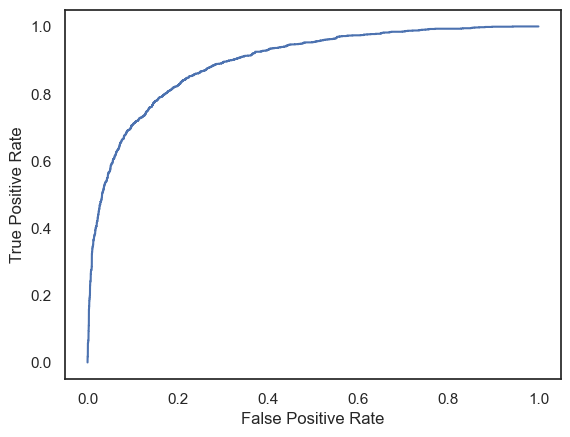

In [95]:
y_scores = smote_2.decision_function(X_test) 

fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=smote_2.classes_[1])


roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc = roc_auc_score(y_test, y_scores)
auc

# we still seeing really good scores with this model! maybe even better than catplot! let's try a grid search!

In [132]:
# smote histbooster grid search 

param_grid = {
    'cat__learning_rate': [.1, .3, .5, .7, 1],
    'cat__max_iter': [10, 50, 100],
    'cat__max_depth': [3,5,7]
}
              
              
grid_search_smote_2 = GridSearchCV(
    estimator=smote_2,
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'
)

grid_search_smote_2.fit(X_test, y_test)

cv_score = grid_search_smote_2.best_score_
test_score = roc_auc_score(y_test, grid_search_smote_2.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')




Cross-validation score: 0.8814414133109464
Test score: 0.8374316834339204


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavi...
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('smote', SMOTE(random_state=42)),
                ('cat', HistGradientBoostingClassifier(max_depth=5))])

In [133]:
print(grid_search_smote_2.best_params_)

{'cat__learning_rate': 0.1, 'cat__max_depth': 5, 'cat__max_iter': 100}


In [134]:
# applying best tuning parameters to our best model:

smote_5 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', HistGradientBoostingClassifier(max_depth=5, learning_rate=.1, max_iter=100))
])

smote_5.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote_5.score(X_train, y_train)
print("Score on resampled data:", score)

Score on resampled data: 0.8848510912805074


In [135]:
cross_validate(smote_5, X_train, y_train, return_train_score=True)

{'fit_time': array([2.93683505, 2.82923388, 2.81151915, 2.71570206, 3.0412159 ]),
 'score_time': array([0.06725979, 0.06258821, 0.06059909, 0.06205606, 0.06112194]),
 'test_score': array([0.86723999, 0.85729643, 0.87177419, 0.87258065, 0.87069892]),
 'train_score': array([0.88777636, 0.89100195, 0.88670878, 0.88691036, 0.88859024])}

0.8939016377432571

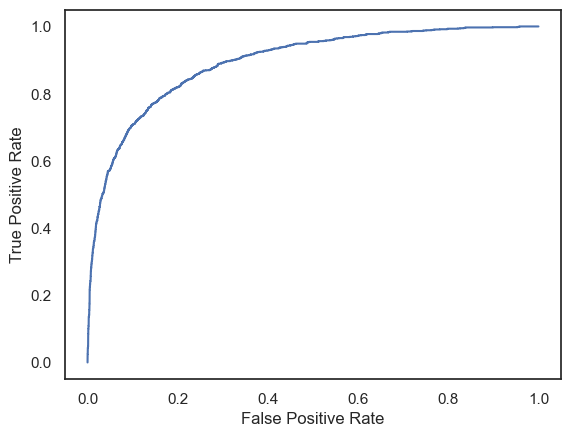

In [178]:
y_scores = smote_5.decision_function(X_test) 

fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=smote_5.classes_[1])


roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc = roc_auc_score(y_test, y_scores)
auc

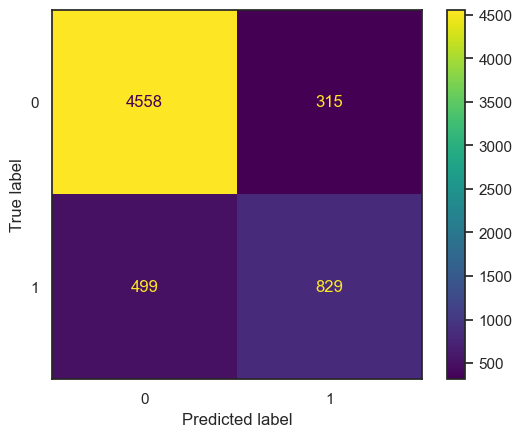

In [137]:
ConfusionMatrixDisplay.from_estimator(smote_5, X_test, y_test)

plt.show()

# a slightly worse confusion matrix than our gradient boost model 

In [ ]:
# best score overall!!! very excited about this model!!! should i pickle it?

In [139]:
# let's look at this awesome model's coefficients or feature selections (if we can!)
# aaand we can't with hgb. isn't supported! we will have to get these from our next-best model, gradient booster


In [160]:
evaluate(smote_5, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8848510912805074
Train Precision: 0.7691632533645407
Train Recall: 0.6602209944751382
Train F1-Score: 0.7105405405405407
**********
Testing Scores:
Test Accuracy: 0.8687308498629254
Test Precision: 0.7246503496503497
Test Recall: 0.6242469879518072
Test F1-Score: 0.6707119741100324


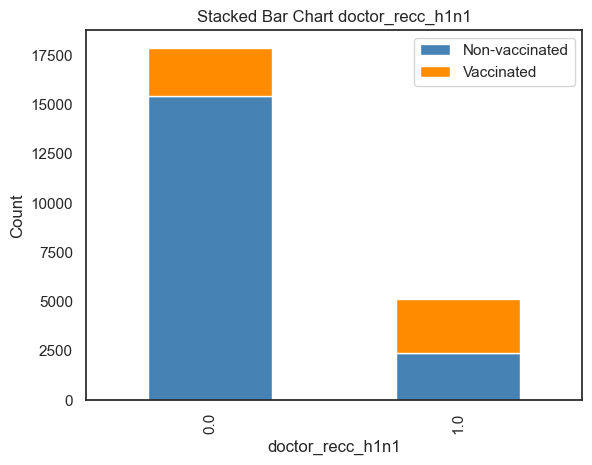

In [180]:
# stacked bar charts for our best features

#make_stacked_chart(merged_filtered, 'age_group', 'h1n1_vaccine')
#make_stacked_chart(merged_filtered, 'opinion_h1n1_vacc_effective', 'h1n1_vaccine')
make_stacked_chart(merged_filtered, 'doctor_recc_h1n1', 'h1n1_vaccine')
#make_stacked_chart(merged_filtered, 'health_insurance', 'h1n1_vaccine')
#make_stacked_chart(merged_filtered, 'doctor_recc_seasonal', 'h1n1_vaccine')
# x0_45 - 54 Years	0.391556
# 15	opinion_h1n1_vacc_effective	0.190900
# 16	opinion_h1n1_risk	0.108949
# 9	doctor_recc_h1n1	0.093502
# 14	health_insurance	0.046240
# 10	doctor_recc_seasonal	0.029098
# 18	opinion_seas_vacc_effective	0.017172
# 64	x10_cfqqtusy	0.011919
# 40	x4_nanx5_Married	0.010823
# 60	x9_Non-MSA	0.010343

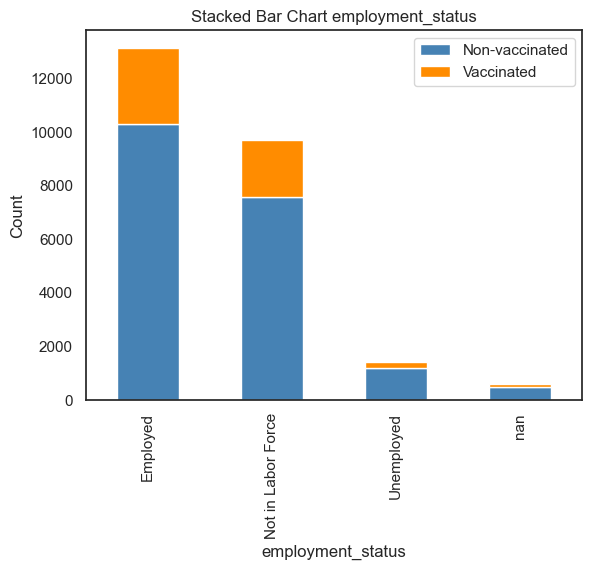

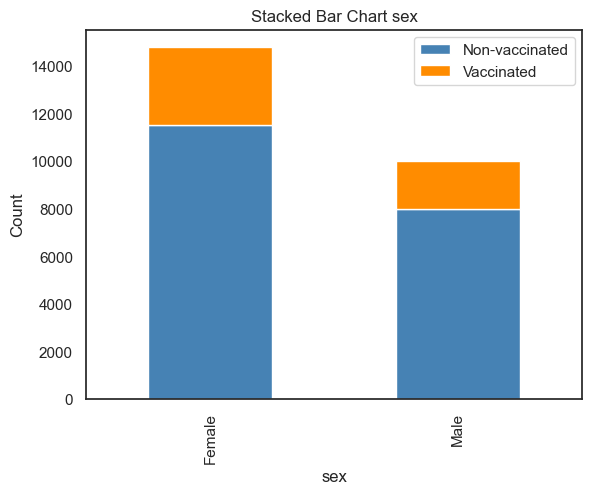

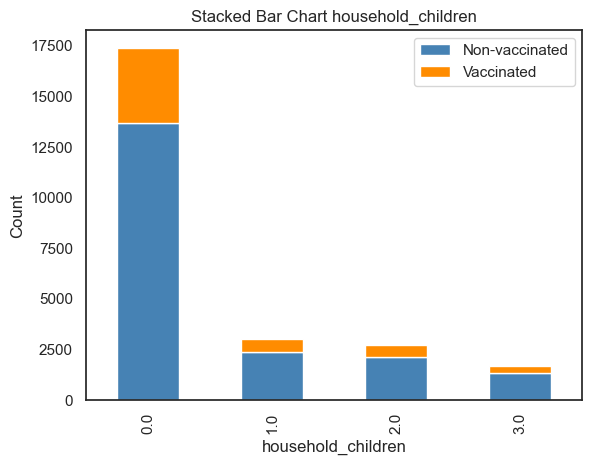

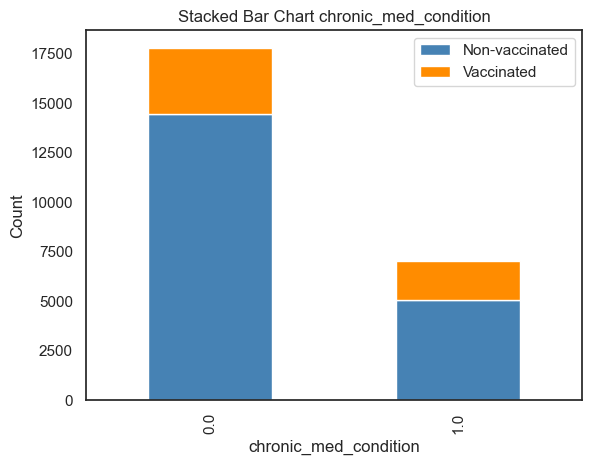

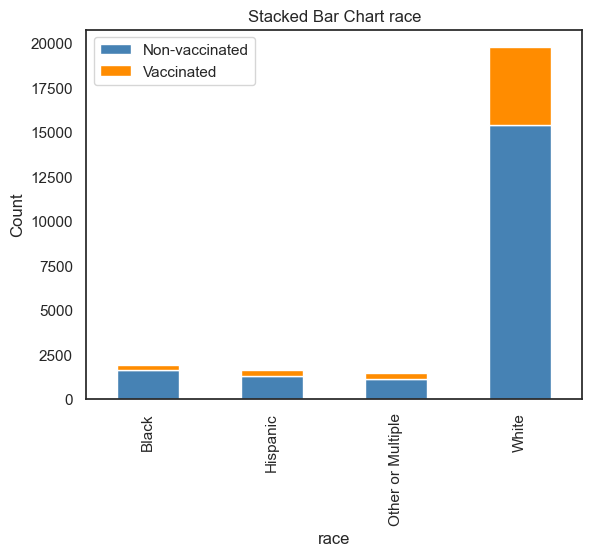

In [156]:

make_stacked_chart(merged_filtered, 'employment_status', 'h1n1_vaccine') # not in labor force
make_stacked_chart(merged_filtered, 'sex', 'h1n1_vaccine') # men 
make_stacked_chart(merged_filtered, 'household_children', 'h1n1_vaccine') # any kids in house
make_stacked_chart(merged_filtered, 'chronic_med_condition', 'h1n1_vaccine') 


In [ ]:
make_stacked_chart(merged_filtered, 'employment_status', 'h1n1_vaccine')

In [154]:
merged_filtered.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [97]:
# last model, catboost!


cbc = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", CatBoostClassifier(iterations=10,learning_rate=.7,depth=7, verbose=False))
])

cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)

cbc.score(X_train, y_train)

# from the website:
# Tree depth
# In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended.

# Note

# The maximum depth of the trees is limited to 8 for pairwise modes 
# (YetiRank, PairLogitPairwise and QueryCrossEntropy) when the training is performed on GPU.



0.8813030856897108

In [98]:
cross_validate(cbc, X_train, y_train, return_train_score=True)



{'fit_time': array([2.05481195, 2.04478312, 2.04874182, 2.016258  , 2.01616406]),
 'score_time': array([0.1518631 , 0.15284586, 0.15290403, 0.15409184, 0.1517899 ]),
 'test_score': array([0.86535877, 0.86320881, 0.8672043 , 0.86801075, 0.86666667]),
 'train_score': array([0.88488677, 0.88623076, 0.8792501 , 0.88187072, 0.8821395 ])}

In [99]:
auc = roc_auc_score(y_test, y_scores)
auc

0.895407507312237

In [100]:
# smote with catboost 
from imblearn.pipeline import Pipeline as Pipeline_2
smote = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', CatBoostClassifier(iterations = 10, learning_rate =.7, depth = 7, verbose = False))
])

smote.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote.score(X_train, y_train)
print("Score on resampled data:", score)

# resampling did not help us, but maybe it reduced overfitting

Score on resampled data: 0.8750134394151167


In [101]:
# cross val on smoted catboost
cross_validate(smote, X_train, y_train, return_train_score=True)

{'fit_time': array([2.78274322, 2.67920685, 2.63622308, 2.63530922, 2.643085  ]),
 'score_time': array([0.15935493, 0.15732408, 0.15643907, 0.15688801, 0.15412617]),
 'test_score': array([0.86562752, 0.85622145, 0.86639785, 0.86666667, 0.86451613]),
 'train_score': array([0.87695719, 0.87944359, 0.87293375, 0.87602473, 0.87763741])}

In [108]:
# gridsearch with smoted catboost

param_grid = {'cat__depth': [3,5,6,8,10],
             'cat__learning_rate': [.3,.5,.7,1]}


grid_search = GridSearchCV(
    estimator=smote,
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'
)

grid_search.fit(X_test, y_test)


cv_score = grid_search.best_score_
test_score = roc_auc_score(y_test, grid_search.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')


Cross-validation score: 0.8801830296551733
Test score: 0.782782371019065


In [109]:
evaluate(cbc, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8813030856897108
Train Precision: 0.7808739708676378
Train Recall: 0.6192867905575088
Train F1-Score: 0.6907563025210084
**********
Testing Scores:
Test Accuracy: 0.865021770682148
Test Precision: 0.7349282296650718
Test Recall: 0.5783132530120482
Test F1-Score: 0.6472819216182047


In [110]:
evaluate(smote, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8750134394151167
Train Precision: 0.735302470888952
Train Recall: 0.650175791059769
Train F1-Score: 0.6901239504198321
**********
Testing Scores:
Test Accuracy: 0.8663118851798097
Test Precision: 0.716017316017316
Test Recall: 0.6227409638554217
Test F1-Score: 0.666129681836488


KeyboardInterrupt: 

In [ ]:
# show off the curve differences of our models
#grid_search.fit(X_train, y_train)

# need to go back and rename some variables here and get the graph



# Plot the ROC curve using RocCurveDisplay
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
fig, ax = plt.subplots(figsize=(10, 10))
RocCurveDisplay(fpr=fpr, tpr=tpr,
               name='Logistic Regssion', ax=ax),
RocCurveDisplay(fpr=fpr, tpr=tpr,
               name='Gradient Boosting Classifier', ax=ax)
RocCurveDisplay(fpr=fpr, tpr=tpr, 
               name='Histogram-based Gradient Boosting Classifer', ax=ax)
RocCurveDisplay(fpr=fpr, tpr=tpr,
               name='Categorical Boosting Classifer', ax=ax);

plt.show()

In [142]:
# nice visualizations of our features!

def make_stacked_chart(df, col, vaccine):
    df_grouped = pd.DataFrame(df.groupby(col)[vaccine].value_counts())
    df_grouped.columns = ['count']
    df_grouped = df_grouped.reset_index()
    
    pivot_df = df_grouped.pivot(index=[col], columns=vaccine, values=['count']).reset_index()
    
    pivot_df.set_index(col).plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'])
    plt.title(f'Stacked Bar Chart {col}')
    plt.legend(['Non-vaccinated', 'Vaccinated'])
    plt.ylabel('Count')
    plt.show()
    
def make_group_barcharts(df, col_list, nrows, ncols, vaccine, tight=False, figx=16, figy=36):
    fig = plt.figure(figsize=(figx, figy))

    for i, col in enumerate(col_list):
        ax = plt.subplot(nrows, ncols, i+1)
        df_grouped = pd.DataFrame(df.groupby(col)[vaccine].value_counts())
        df_grouped.columns = ['count']
        df_grouped = df_grouped.reset_index()
    
        pivot_df = df_grouped.pivot(index=[col], columns=vaccine, values=['count']).reset_index()
    
        pivot_df.set_index(col).plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'], ax = ax)
        plt.title(f'Stacked Bar Chart {col}')
        plt.legend(['Non-vaccinated', 'Vaccinated'])
        plt.ylabel('Count')
        
    if tight:
        plt.tight_layout()

In [ ]:
# gonna come back to this later

# from sklearn.multioutput import MultiOutputClassifier
# y_train 
# moc = Pipeline([
#     ("preprocessor", preprocessor),
#     ("estimators", MultiOutputClassifier(estimator=LogisticRegression()))
# ])

# moc.fit(X_train, y_train)

# y_pred = moc.predict(X_test)

# moc.score(X_train, y_train)


# error: y must have at least two dimensions for multi-output regression but has only one.

# for shits and giggles, let's re-define 7 just for this case


In [ ]:
# mlb = MultiLabelBinarizer()
# y_train_binarized = mlb.fit_transform(y_train)
# y_test_binarized = mlb.fit_transform(y_test)

# save this for a later date, when we want to predit multilabel data. a lot of models don't accept these. vectorized type does.

In [ ]:
# from catboost.utils import get_roc_curve
# catboost_pool = Pool(X_train, y_train)
# smote.fit(X_train, y_train, verbose=False)
# (fpr, tpr, thresholds) = get_roc_curve(smote, catboost_pool, plot=True)
# print(fpr)
# print(tpr)
# print(thresholds)

# need to clean up this mixed data to use this 
# error: CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=21]="65+ Years": Cannot convert 'b'65+ Years'' to float


In [ ]:
# look at later

# grid_search.cv_results_